# Out  of Disterbution

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
import json
import pandas as pd
import copy
import seaborn as sns
import sys
from scipy.interpolate import make_interp_spline, BSpline
%run ./result_summary.ipynb
%run ./plot_functions.ipynb
sys.path.insert(0, '../src/')

output_path =  ../output/figures
plt = single_column_plt_params(plt)


In [2]:
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
from distributions_metrics import *
plt = single_column_plt_params(plt)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Load svhn and noise
results_df_cifar10, statistic_cifar10 = load_results_to_df(files_nml_2_layers)
print('Cifar10: loaded %d keys' % results_df_cifar10.shape[0])
results_df_noise, statistic_noise = load_results_to_df(
    files_noise, is_out_of_dist=True)
print('Noise: loaded %d keys' % results_df_noise.shape[0])
results_df_svhn, statistic_svhn = load_results_to_df(
    files_svhn, is_out_of_dist=True)
print('SVHN: loaded %d keys' % results_df_svhn.shape[0])

Cifar10: loaded 10000 keys
Noise: loaded 100 keys
SVHN: loaded 100 keys


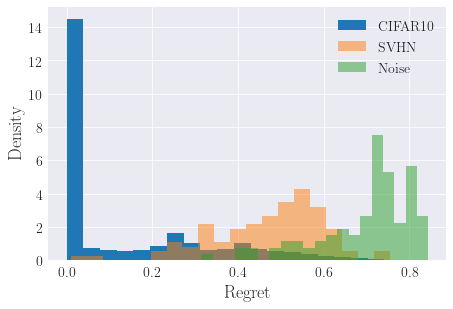

Mean: cifar, svhn, noise: [0.13991651419091314, 0.47305804001135926, 0.6994421087314094]


In [4]:
# Plot
bins = 20
plt.hist(results_df_cifar10['log10_norm_factor'],
         alpha=1, density=True, label='CIFAR10', bins=bins)
plt.hist(results_df_svhn['log10_norm_factor'],
         alpha=0.5, density=True, label='SVHN', bins=bins)
plt.hist(results_df_noise['log10_norm_factor'],
         alpha=0.5, density=True, label='Noise', bins=bins)
plt.ylabel('Density')
plt.xlabel('Regret')
plt.title('Out Of Distribution Regret Histogram') if is_plot_title else None
plt.legend()
plt.savefig(os.path.join(output_path, 'figure_out_of_dist_hist.pdf'),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()
print('Mean: cifar, svhn, noise: {}'.format([results_df_cifar10['log10_norm_factor'].mean(),
                                             results_df_svhn['log10_norm_factor'].mean(
),
    results_df_noise['log10_norm_factor'].mean()]))

## Entropy

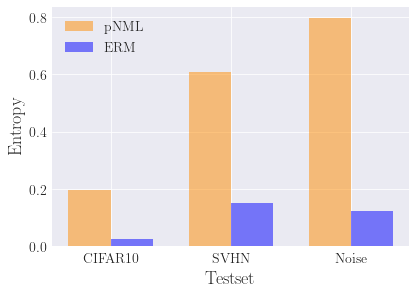


SVHN:
                   nml       erm
acc           0.080000  0.070000
mean loss          NaN       NaN
std loss           NaN       NaN
mean entropy  0.606728  0.151538

Noise:
                   nml       erm
acc           0.000000  0.000000
mean loss          NaN       NaN
std loss           NaN       NaN
mean entropy  0.794805  0.123688


In [5]:
# Plot entropy
objects = ('CIFAR10', 'SVHN', 'Noise')
y_pos = np.arange(len(objects))
bar_width = 0.35
opacity = 0.8

plt.bar(y_pos - bar_width / 2, [statistic_cifar10.loc['mean entropy']['nml'],
                                statistic_svhn.loc['mean entropy']['nml'],
                                statistic_noise.loc['mean entropy']['nml']],
        bar_width, alpha=0.5, color='darkorange', label='pNML')

plt.bar(y_pos + bar_width / 2, [statistic_cifar10.loc['mean entropy']['erm'],
                                statistic_svhn.loc['mean entropy']['erm'],
                                statistic_noise.loc['mean entropy']['erm']],
        bar_width, alpha=0.5, color='blue', label='ERM')

plt.xticks(y_pos, objects)
plt.ylabel('Entropy')
plt.title('Entropy of out of distribution sampels') if is_plot_title else None
plt.legend()
plt.xlabel('Testset')
# plt.savefig(os.path.join(output_path, 'figure_out_of_dist_entropy.pdf'),
#             dpi=300, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

print()
print('SVHN:')
print(statistic_svhn)

print()
print('Noise:')
print(statistic_noise)

## Evaluation metrics

Upsample ratio:  100
Noise:
             KL Divergence  Bhattach Distance  KL in P_lamb
Max Prob          0.793541           0.187877      0.192254
1-p2/p1           0.642972           0.161719      0.163609
1 - Entropy       3.368564           0.348873      0.373464
Regret            3.583605           0.652462      0.658781



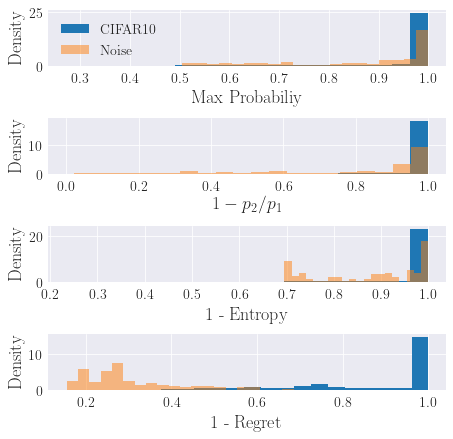

Upsample ratio:  100
SVHN:
             KL Divergence  Bhattach Distance  KL in P_lamb
Max Prob          0.777065           0.189231      0.192212
1-p2/p1           0.701389           0.151679      0.153012
1 - Entropy       1.700309           0.341264      0.344167
Regret            2.949852           0.516624      0.535095



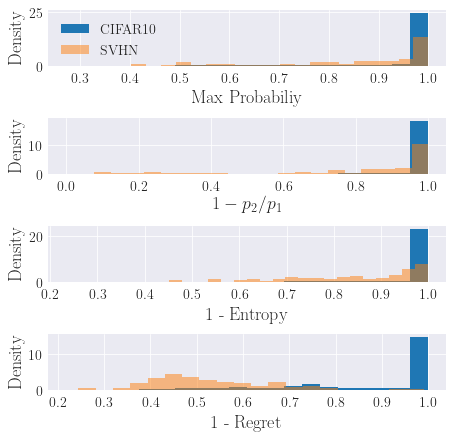

In [32]:
from numpy import inf
ind_df = results_df_cifar10
for (ooo_dataset, ood_df) in zip(['Noise', 'SVHN'], [results_df_noise, results_df_svhn]):
    upsample_ratio = int(ind_df.shape[0] / ood_df.shape[0])
    print('Upsample ratio: ', upsample_ratio)

    # Baseline Max prob of ERM
    y_score_ind = ind_df[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist() + \
        ood_df[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ood_df.shape[0]
    ood_df_erm_baseline = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_erm_baseline = ood_df_erm_baseline.rename(index={0: 'Max Prob'})

    # Baseline p1/p2 of ERM
    p1_ind = np.sort(ind_df[['erm_' + str(x)
                             for x in range(10)]])[:, -2:][:, 1]
    p2_ind = np.sort(ind_df[['erm_' + str(x)
                             for x in range(10)]])[:, -2:][:, 0]
    p1_p2_ind = 1-p2_ind/p1_ind  # np.clip(p1_ind/p2_ind, 0, 10**6)
    p1_ood = np.sort(ood_df[['erm_' + str(x)
                             for x in range(10)]])[:, -2:][:, 1]
    p2_ood = np.sort(ood_df[['erm_' + str(x)
                             for x in range(10)]])[:, -2:][:, 0]
    p1_p2_ood = 1-p2_ood/p1_ood  # np.clip(p1_ood/p2_ood, 0, 10**6)

    y_score_ind = list(p1_p2_ind) + list(p1_p2_ood)
    y_true_ind = [True] * ind_df.shape[0] + [False] * ood_df.shape[0]
    ood_df_erm_baseline_2 = calc_performance_in_out_dist(
        y_true_ind, y_score_ind)
    ood_df_erm_baseline_2 = ood_df_erm_baseline_2.rename(index={0: '1-p2/p1'})
    
    # Entropy
    y_score_ind = (1.0 - ind_df['erm_entropy']).tolist() + \
        (1.0 - ood_df['erm_entropy']).tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ood_df.shape[0]
    ood_df_erm_baseline_3 = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_erm_baseline_3 = ood_df_erm_baseline_3.rename(index={0: '1 - Entropy'})
    
    # Regret based
    y_score_ind = (1.0 - ind_df['log10_norm_factor']).tolist() + \
                  (1.0 - ood_df['log10_norm_factor']).tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ood_df.shape[0]

    ood_df_ours = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_ours = ood_df_ours.rename(index={0: 'Regret'})

    # Summary
    merged_pd = pd.concat(
        [ood_df_erm_baseline, ood_df_erm_baseline_2,ood_df_erm_baseline_3, ood_df_ours])
    print('%s:' % ooo_dataset)
    print(merged_pd)
    print()

    # Histogram based on Ouf Of Dist confidence
    width, height = plt.rcParams.get('figure.figsize')
    f, axarr = plt.subplots(4, 1, figsize=(width,1.4*height))
    nbins = 20
    axarr[0].hist(ind_df[['erm_' + str(x) for x in range(10)]
                         ].max(axis=1),  bins=nbins, alpha=1.0, density=True, label='CIFAR10')
    axarr[0].hist(ood_df[['erm_' + str(x) for x in range(10)]
                         ].max(axis=1),  bins=nbins, alpha=0.5, density=True, label=ooo_dataset)
    axarr[0].set_xlabel('Max Probabiliy')
    axarr[0].set_ylabel('Density')
    axarr[0].legend()

    axarr[1].hist(list(p1_p2_ind), bins=nbins,
                  alpha=1.0, density=True, label='In-Dist')
    axarr[1].hist(list(p1_p2_ood), bins=nbins,
                  alpha=0.5, density=True, label=ooo_dataset)
    axarr[1].set_xlabel(r'$1-p_2 / p_1$')
    axarr[1].set_ylabel('Density')
    
    axarr[2].hist(list(1 - ind_df['erm_entropy']), bins=nbins,
                  alpha=1.0, density=True, label='In-Dist')
    axarr[2].hist(list(1 - ood_df['erm_entropy']), bins=nbins,
                  alpha=0.5, density=True, label=ooo_dataset)
    axarr[2].set_xlabel(r'1 - Entropy')
    axarr[2].set_ylabel('Density')

    axarr[3].hist(1.0 - ind_df['log10_norm_factor'], bins=nbins,
                  alpha=1.0, density=True, label='In-Dist')
    axarr[3].hist(1.0 - ood_df['log10_norm_factor'], bins=nbins,
                  alpha=0.5, density=True, label=ooo_dataset)
    axarr[3].set_xlabel('1 - Regret')
    axarr[3].set_ylabel('Density')

    f.subplots_adjust(hspace=0.6)
    plt.savefig(os.path.join(output_path, 'figure_out_of_dist_detection_%s.pdf' % ooo_dataset),
                dpi=300, bbox_inches=plt.tight_layout()) if is_save_fig else None
    plt.show()